# First data visualizations 

We have identify a list of columns which can be used for learning. 
We are not interested in the columns with data "at_retrieval" because it can contain information arriving after the request has been satisfied (thanks for example). Similarly any information concerning the giver are not relevant. Moreover we will use only the request_text_edit_aware because the requst_text columns can contains modifications on the raw message arriving after the request has been satisfied.  

the goal of this section is to do quick univariate analysis on these variables to give us a sens a better understanding of the dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from scipy import stats
from mlxtend.frequent_patterns import apriori
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from scipy import sparse
import statsmodels.api as sm
from statsmodels.formula.api import ols
from auxiliary_functions import print_raop_request

raw_data = pd.read_pickle("../Data/enriched_data.pkl")
figure_path = "../Figures"

In [2]:
f"The overall proportion of succesfull request is : {raw_data.requester_received_pizza.sum()/raw_data.shape[0]}"

'The overall proportion of succesfull request is : 0.24603960396039604'

# Numerical variables visualization

## Study distributions

In [3]:
numerical_columns = ['requester_account_age_in_days_at_request', 'requester_days_since_first_post_on_raop_at_request', 
                     'requester_number_of_comments_at_request','requester_number_of_comments_in_raop_at_request', 
                     'requester_number_of_posts_at_request', 'requester_number_of_posts_on_raop_at_request', 
                     'requester_number_of_subreddits_at_request', 'requester_upvotes_minus_downvotes_at_request', 
                     'requester_upvotes_plus_downvotes_at_request', 'request_year', 'request_month', 'request_day', 
                     'request_hour', 'request_weekday', 'request_edit_aware_length', 'requester_upvotes_at_request', 
                     'requester_downvotes_at_request', 'has_picture', 'has_link']

We plot the distribution of each numerical variable. The results can be found in the "Figures" folder at the root of the project. 
We plot the distributions by group successfull/unsuccessfull request. We make a median equality test to test between the two groups to see if we can expect the variable to have a string influence on the sucess. 

In [4]:
for col in numerical_columns:
    median_eq_test = stats.kruskal(raw_data.loc[raw_data.requester_received_pizza, col],
                                   raw_data.loc[~raw_data.requester_received_pizza, col])
    plt.figure(figsize=(10, 8))
    sns.violinplot(data=raw_data, x="requester_received_pizza", y=col)
    plt.grid()
    plt.title(f"{col} \n krustal test median equality p value {median_eq_test.pvalue}")
    plt.savefig(f"{figure_path}/distrib_{col}.png")
    plt.close()

The table bellow summarises the influence of the different variables according to the median equality test. 

In [5]:
raw_data["requester_received_pizza_num"] = raw_data.requester_received_pizza.astype(int)
formula = 'requester_received_pizza_num ~ {}'.format(" + ".join(numerical_columns))
model = ols(formula, data=raw_data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table.sort_values('PR(>F)')

,sum_sq,df,F,PR(>F)
request_year,12.287397,1.0,70.537533,6.183897e-17
request_edit_aware_length,6.618775,1.0,37.996008,7.786287e-10
requester_number_of_posts_on_raop_at_request,5.694220,1.0,32.688468,1.160276e-08
request_month,4.697592,1.0,26.967186,2.171784e-07
has_picture,2.129746,1.0,12.226108,4.763490e-04
requester_number_of_comments_in_raop_at_request,2.094160,1.0,12.021821,5.313214e-04
requester_days_since_first_post_on_raop_at_request,1.557129,1.0,8.938917,2.808489e-03
requester_account_age_in_days_at_request,1.398312,1.0,8.027204,4.630937e-03
request_day,1.254459,1.0,7.201398,7.314510e-03
requester_number_of_subreddits_at_request,0.440197,1.0,2.527013,1.119905e-01


The distribution of down/up votes variables, as well as the distribution of variables related to the number of posts, are very skewed. When choosing the final model, we should be carefull with that.

## A few more plots

Text(0.5, 1.0, 'Sucess rate as a function of the length of the request (number of words)')

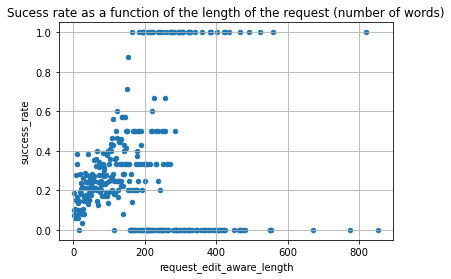

In [6]:
rq_lg = raw_data.groupby(["request_edit_aware_length", "requester_received_pizza"]).size().reset_index()
rq_lg.rename({0: 'count'}, axis=1, inplace=True)
rq_lg.requester_received_pizza = rq_lg.requester_received_pizza.astype(str)
rq_lg = pd.pivot_table(rq_lg, values='count', index='request_edit_aware_length', columns=['requester_received_pizza'], fill_value=0).reset_index()
rq_lg["success_rate"] = rq_lg["True"] / (rq_lg["True"] + rq_lg["False"])

rq_lg.plot.scatter(x="request_edit_aware_length", y="success_rate")
plt.grid()
plt.title("Sucess rate as a function of the length of the request (number of words)")

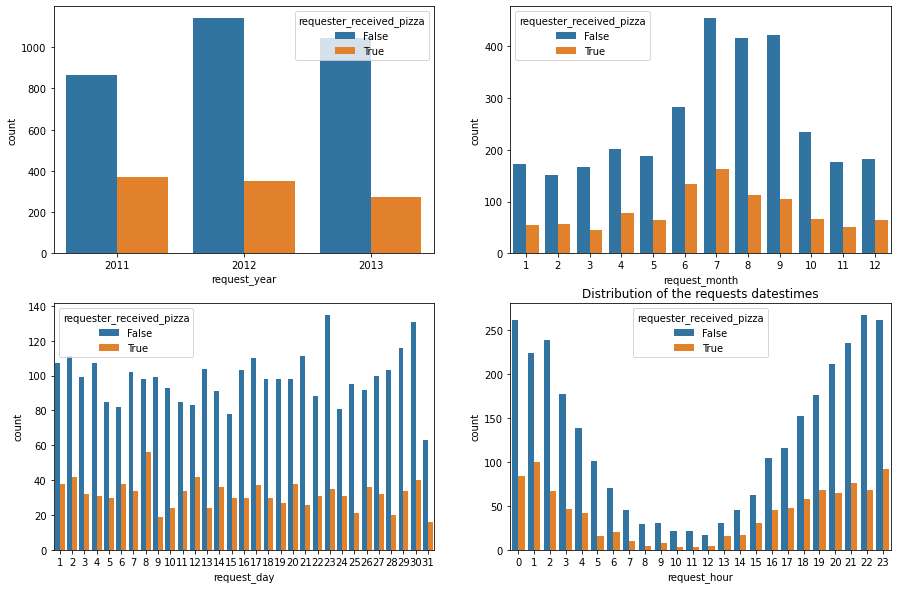

In [7]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
plt.title("Distribution of the requests datestimes")
sns.countplot(x="request_year", hue="requester_received_pizza", data=raw_data, ax=axs[0,0])
sns.countplot(x="request_month", hue="requester_received_pizza", data=raw_data, ax=axs[0,1])
sns.countplot(x="request_day", hue="requester_received_pizza", data=raw_data, ax=axs[1,0])
sns.countplot(x="request_hour", hue="requester_received_pizza", data=raw_data, ax=axs[1,1])

# Request text visualisation

In [8]:
def get_wordcloud(pd_serie, added_stop_words={}):
    concatenated_text = " ".join(narrative.lower() for narrative in pd_serie)
    word_cloud = WordCloud(stopwords=STOPWORDS.union(added_stop_words), background_color="white").generate(concatenated_text)
    return word_cloud

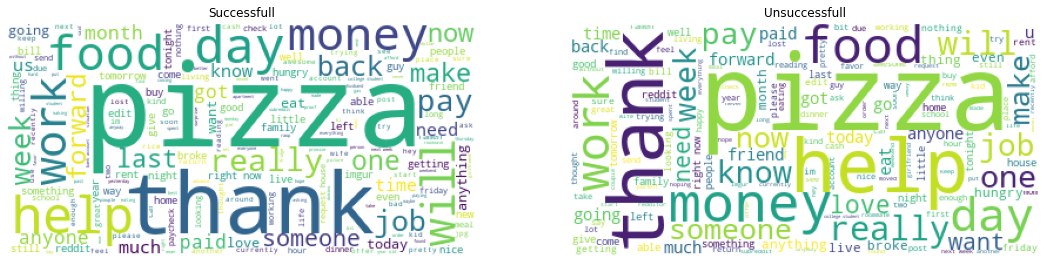

In [9]:
success_wc = get_wordcloud(raw_data.loc[raw_data.requester_received_pizza, "request_text_edit_aware"])
fail_wc = get_wordcloud(raw_data.loc[~raw_data.requester_received_pizza, "request_text_edit_aware"])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(success_wc)
axs[0].axis('off')
axs[0].set_title("Successfull")
axs[1].imshow(fail_wc)
axs[1].axis('off')
axs[1].set_title("Unsuccessfull")
fig.set_size_inches(18.5, 10.5)

A quick look at the wordclouds doesn(t give us any clear clue on what could influence the success. 

# Request title analysis

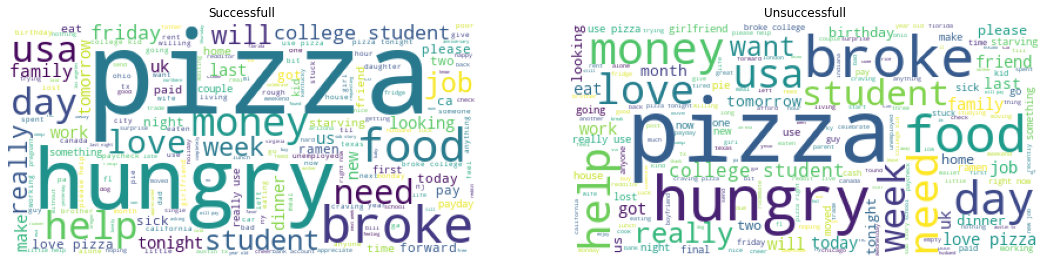

In [10]:
success_wc = get_wordcloud(raw_data.loc[raw_data.requester_received_pizza, "request_title"], added_stop_words={'request'})
fail_wc = get_wordcloud(raw_data.loc[~raw_data.requester_received_pizza, "request_title"], added_stop_words={'request'})

fig, axs = plt.subplots(1, 2)
axs[0].imshow(success_wc)
axs[0].axis('off')
axs[0].set_title("Successfull")
axs[1].imshow(fail_wc)
axs[1].axis('off')
axs[1].set_title("Unsuccessfull")
fig.set_size_inches(18.5, 10.5)

A quick look at the wordclouds doesn't give us any clear clue on what could influence the success. 

# Subreddits column analysis

In [11]:
# Transform the subreddit column into a matrix with all possible groups in columns
# and all requests in row. We have a 1 in case (i,j) if the requester i
# belongs to the subreddit j, 0 otherwise
vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words=None, lowercase=False, 
                             token_pattern='(?u)[^\s]+', min_df=3
                            ) # Token are splitted by space only, exclude word appearing only twice with min_df
vectorize_subreddits = vectorizer.fit_transform(raw_data.requester_subreddits_at_request_text)

In [12]:
# Look at the most popular subreddits in our data set
vocab_subreddits = pd.Series(vectorizer.vocabulary_)
vocab_subreddits = vocab_subreddits.reset_index()
vocab_subreddits.columns = ['n_gram', 'vocab_col_number']
vocab_subreddits['text_type'] = 'requester_subreddits_at_request'
vocab_subreddits.set_index('vocab_col_number', inplace=True)
vocab_subreddits.sort_index(axis=0, inplace=True)
df_subreddits = pd.DataFrame(vectorize_subreddits.toarray(), columns=vocab_subreddits.n_gram.to_list())
df_subreddits.sum().sort_values(ascending=False).iloc[:10,]

AskReddit               2307
pics                    1949
funny                   1932
WTF                     1515
IAmA                    1507
gaming                  1485
Random_Acts_Of_Pizza    1413
videos                  1160
todayilearned           1103
AdviceAnimals           1021
dtype: int64

We now compare the sureddits of successfull requesters with subreddits of unsucessfull requester. We restrict ourselves to subreddits conserning more than 30% of the population. 

In [16]:
# Using the frequent pattern matching algorithm "apriori" to do that. (This is a complicated way of
# of doing something simple but we started doing that to explore a little bit more the groups of subreddits
# and kept it this way).  
min_support = 0.3
frequent_itemsets_success = apriori(df_subreddits.loc[raw_data.requester_received_pizza,], min_support=min_support, 
                                   use_colnames=True, max_len=1)
frequent_itemsets_fail = apriori(df_subreddits.loc[~raw_data.requester_received_pizza,], min_support=min_support, 
                                use_colnames=True, max_len=1)

In [14]:
print("Subreddit groups of succesfull requester \n")
print(frequent_itemsets_success)
print("\n Subreddit groups of unsucessfull requester \n")
print(frequent_itemsets_fail)

Subreddit groups of succesfull requester 

    support                itemsets
0  0.638833             (AskReddit)
1  0.415493                  (IAmA)
2  0.413481  (Random_Acts_Of_Pizza)
3  0.415493                   (WTF)
4  0.532193                 (funny)
5  0.403421                (gaming)
6  0.544266                  (pics)
7  0.302817         (todayilearned)
8  0.317907                (videos)

 Subreddit groups of unsucessfull requester 

    support                itemsets
0  0.548917             (AskReddit)
1  0.359160                  (IAmA)
2  0.328956  (Random_Acts_Of_Pizza)
3  0.361786                   (WTF)
4  0.460604                 (funny)
5  0.355877                (gaming)
6  0.462246                  (pics)


We see that the most popular groups are the same in both populations. However the successfull population belongs in general to more groups (which is also correlated to how old the requester is in the community). 